# Movie Revenue Correlation Analysis

**Project name:** Movies_Correlation.ipynb


**Objective:** Analyze relationships between movie features (budget, gross, score, company, year, etc.) and identify which features are most correlated with a movie's box office gross.


**Dataset:** `movies.csv`

## 1. Setup — imports and global settings


This cell imports libraries, sets plotting styles and notebook-friendly display options.

In [3]:
# Standard imports for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Notebook display / plotting niceties

%matplotlib inline

plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (12, 8)
pd.options.mode.chained_assignment = None

## 2. Load dataset


Loads the CSV file into a DataFrame. For portability, the code tries a couple of common paths and falls back to a user-provided path variable.

In [5]:
df = pd.read_csv(r'C:\Users\venka\OneDrive\Documents\movies.csv')

In [6]:
# Quick shape check
print('\nDataset shape:', df.shape)


Dataset shape: (7668, 15)


## 3. Quick look at the data


Shows first rows and a compact info summary (dtypes, non-null counts). This helps us decide cleaning steps.

In [7]:
print('\n-- head of dataset --')
df.head()


-- head of dataset --


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [8]:
print('\n-- info --')
df.info()


-- info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


## 4. Missing values and basic diagnostics


Computes the percentage of missing values per column and list columns with object dtype. We'll use this to decide which columns need cleaning or encoding.

In [9]:
missing_pct = df.isnull().mean() * 100
print('\nMissing values (%) per column:')
print(missing_pct.round(2))


print('\n\nColumns and dtypes:')
print(df.dtypes)


Missing values (%) per column:
name         0.00
rating       1.00
genre        0.00
year         0.00
released     0.03
score        0.04
votes        0.04
director     0.00
writer       0.04
star         0.01
country      0.04
budget      28.31
gross        2.46
company      0.22
runtime      0.05
dtype: float64


Columns and dtypes:
name         object
rating       object
genre        object
year          int64
released     object
score       float64
votes       float64
director     object
writer       object
star         object
country      object
budget      float64
gross       float64
company      object
runtime     float64
dtype: object


## 5. Data cleaning & Type conversions


Makes safe conversions for `budget` and `gross`. If these columns contain NaN or are not numeric, we fill or coerce appropriately. We also:
- Create a `year` column extracted from a `released` / `release_date`-like column if available
- Drop exact duplicate rows (if any)
- Trim whitespace for string columns (optional but helpful)

In [10]:
# Work on a copy to be safe
df_clean = df.copy()

In [12]:
# Strip whitespace for object columns (helps later when grouping by names)
for c in df_clean.select_dtypes(include=['object']).columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

In [14]:
# Convert budget and gross to numeric where possible
for col in ['budget', 'gross']:
    if col in df_clean.columns:
        # coerce errors -> NaN, then fill with 0 (or keep NaN if you prefer)
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).astype('int64')

In [16]:
# If there is a released / release_date column, try to extract year information
release_candidates = [c for c in df_clean.columns if 'release' in c.lower() or 'released' in c.lower() or 'year' in c.lower()]
if release_candidates:
    # prefer an exact match 'released' if exists
    chosen = None
    if 'released' in df_clean.columns:
        chosen = 'released'
    else:
        chosen = release_candidates[0]


    # Create Year in multiple robust ways
    try:
        # If column is already datetime-like
        df_clean['year_extracted'] = pd.to_datetime(df_clean[chosen], errors='coerce').dt.year
    except Exception:
        df_clean['year_extracted'] = pd.to_datetime(df_clean[chosen].astype(str), errors='coerce').dt.year


    # For cases like 'Released: Month Day, Year' or 'Month Day Year' or 'Year'
    if df_clean['year_extracted'].isnull().all():
        # fallback: take the last token if splitting by whitespace
        df_clean['year_extracted'] = df_clean[chosen].astype(str).str.split().str[-1].str.extract(r'(\d{4})').astype(float)


else:
    # no release-like column
    df_clean['year_extracted'] = np.nan

In [17]:
# Drop exact duplicate rows
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
after = len(df_clean)
print(f"Dropped {before-after} duplicate rows")

Dropped 0 duplicate rows


In [18]:
# Show cleaned dtypes
print('\nCleaned dtypes:')
print(df_clean[['budget','gross','year_extracted']].dtypes)


Cleaned dtypes:
budget              int64
gross               int64
year_extracted    float64
dtype: object


## 6. Exploratory Data Analysis (EDA) — distributions & outliers


Visualizes distributions for `budget` and `gross`. Boxplots and histograms help identify outliers and scale differences.

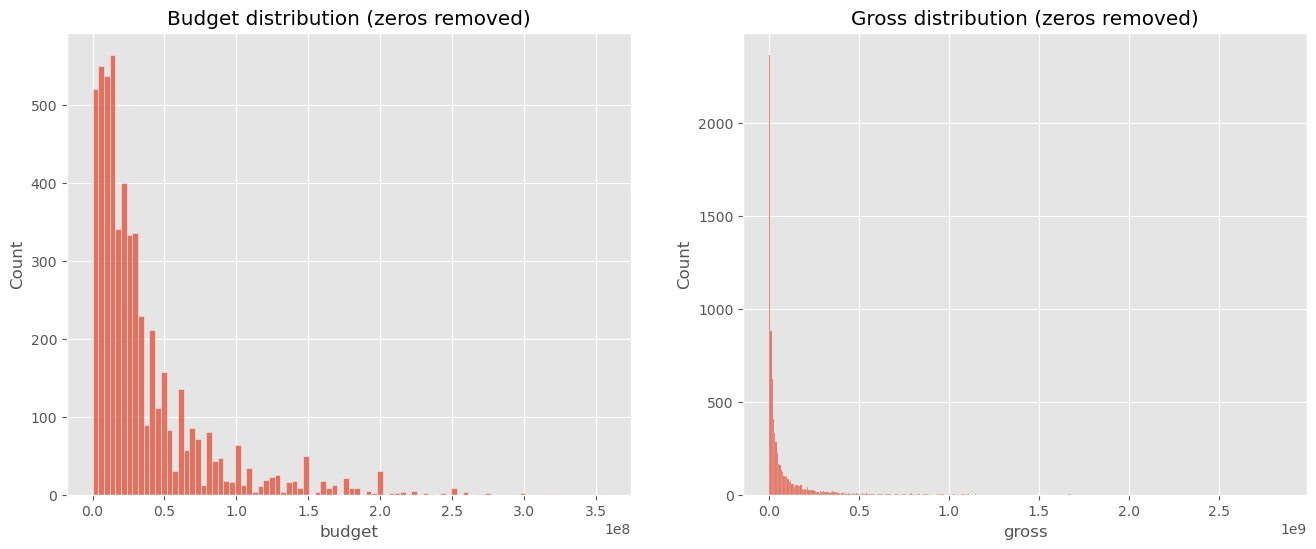

In [19]:
# Histogram for budget and gross (log-transform for visualization if needed)
fig, axes = plt.subplots(1, 2, figsize=(16,6))


sns.histplot(df_clean['budget'].replace(0, np.nan).dropna(), kde=False, ax=axes[0])
axes[0].set_title('Budget distribution (zeros removed)')


sns.histplot(df_clean['gross'].replace(0, np.nan).dropna(), kde=False, ax=axes[1])
axes[1].set_title('Gross distribution (zeros removed)')


plt.show()

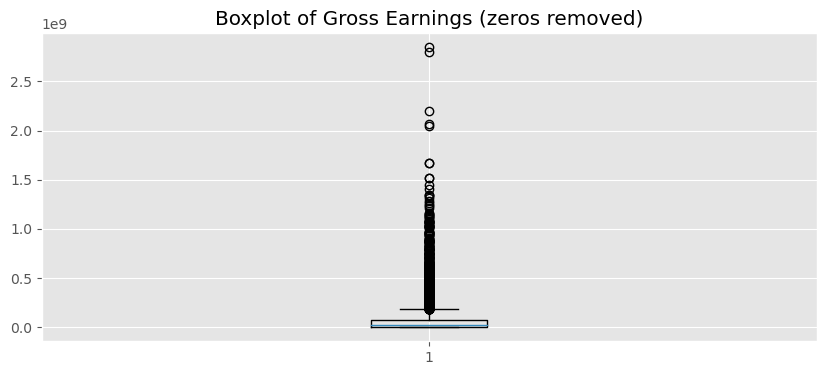

In [20]:
# Boxplot for gross
plt.figure(figsize=(10,4))
plt.boxplot(df_clean['gross'].replace(0, np.nan).dropna())
plt.title('Boxplot of Gross Earnings (zeros removed)')
plt.show()

## 7. Simple scatter & Regression plots


Scatter plots with regression lines provide a quick intuition for linear relationships between two numeric features.

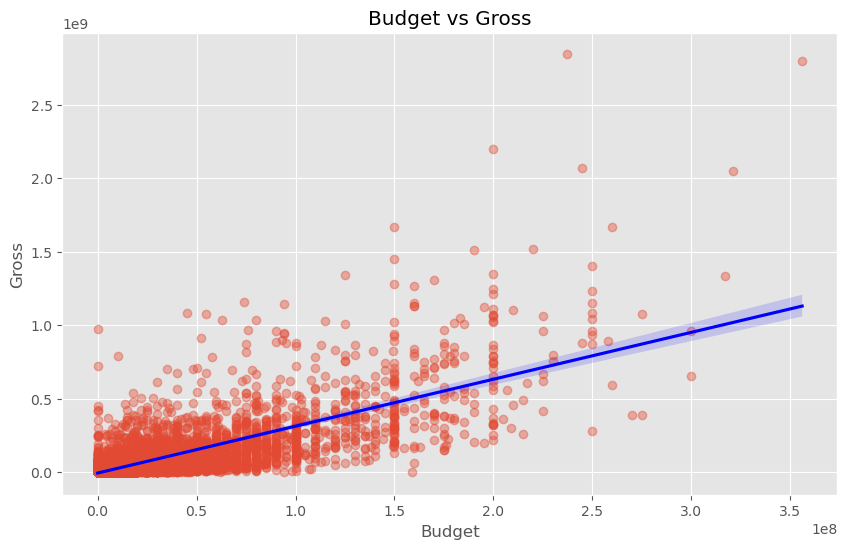

In [42]:
# Budget vs Gross scatter + regression
plt.figure(figsize=(10,6))
sns.regplot(x='budget', y='gross', data=df_clean, scatter_kws={'alpha':0.4}, line_kws={'color':'blue'})
plt.title('Budget vs Gross')
plt.xlabel('Budget')
plt.ylabel('Gross')
plt.show()

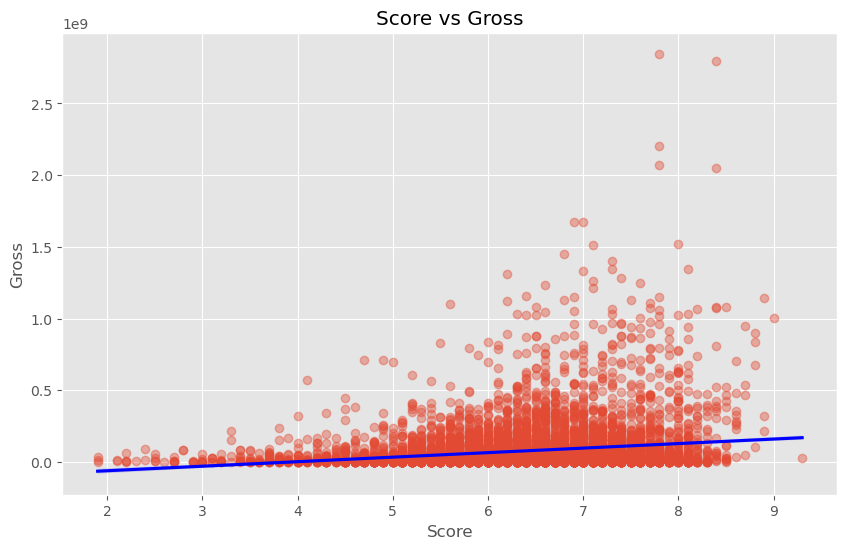

In [43]:
# Score vs Gross (if 'score' exists)
if 'score' in df_clean.columns:
    plt.figure(figsize=(10,6))
    sns.regplot(x='score', y='gross', data=df_clean, scatter_kws={'alpha':0.4}, line_kws={'color':'blue'})
    plt.title('Score vs Gross')
    plt.xlabel('Score')
    plt.ylabel('Gross')
    plt.show()

## 8. Correlation analysis — numeric features


Computes Pearson correlation for numeric features. 
Pearson measures linear correlation; 
we also show Spearman which measures monotonic relationships and is robust to non-normal distributions.

In [24]:
# Select numeric columns
numeric_df = df_clean.select_dtypes(include=[np.number])


print('\nNumeric columns used for correlation:')
print(numeric_df.columns.tolist())


Numeric columns used for correlation:
['year', 'score', 'votes', 'budget', 'gross', 'runtime', 'year_extracted']


In [25]:
# Pearson correlation matrix
pearson_corr = numeric_df.corr(method='pearson')
print('\nPearson correlation (excerpt):')
pearson_corr


Pearson correlation (excerpt):


,year,score,votes,budget,gross,runtime,year_extracted
year,1.000000,0.097995,0.222945,0.309212,0.261900,0.120811,NaN
score,0.097995,1.000000,0.409182,0.055665,0.186392,0.399451,NaN
votes,0.222945,0.409182,1.000000,0.486862,0.632834,0.309212,NaN
budget,0.309212,0.055665,0.486862,1.000000,0.750157,0.269510,NaN
gross,0.261900,0.186392,0.632834,0.750157,1.000000,0.245235,NaN
runtime,0.120811,0.399451,0.309212,0.269510,0.245235,1.000000,NaN
year_extracted,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 9. Visualize correlation matrix (heatmap)


A heatmap with annotations helps surface the strongest correlations quickly.

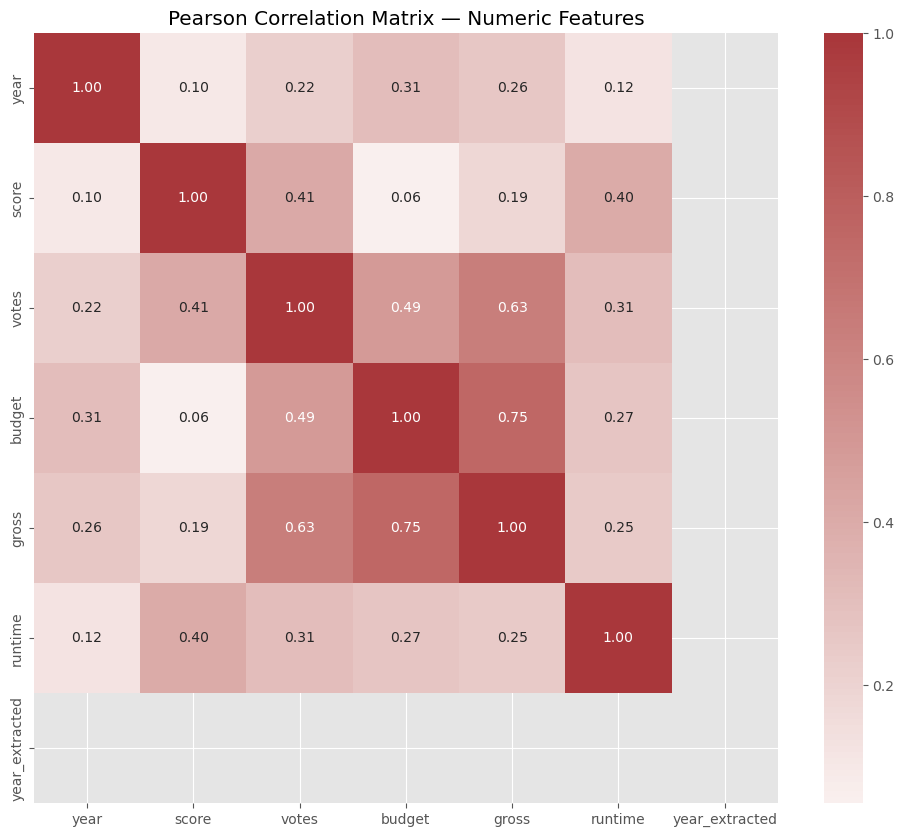

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Pearson Correlation Matrix — Numeric Features')
plt.show()

## 10. Encode categorical features and recompute correlations

Many potentially useful columns (like `company`, `genre`, `director`) are object dtype. Encoding them to integer codes allows us to compute correlations — useful for exploratory signal detection but interpret encoded correlations with care.

In [27]:
# Create a numerized copy where categories are converted to integer codes
df_numerized = df_clean.copy()
for col in df_numerized.columns:
    if df_numerized[col].dtype == 'object':
        df_numerized[col] = df_numerized[col].astype('category').cat.codes

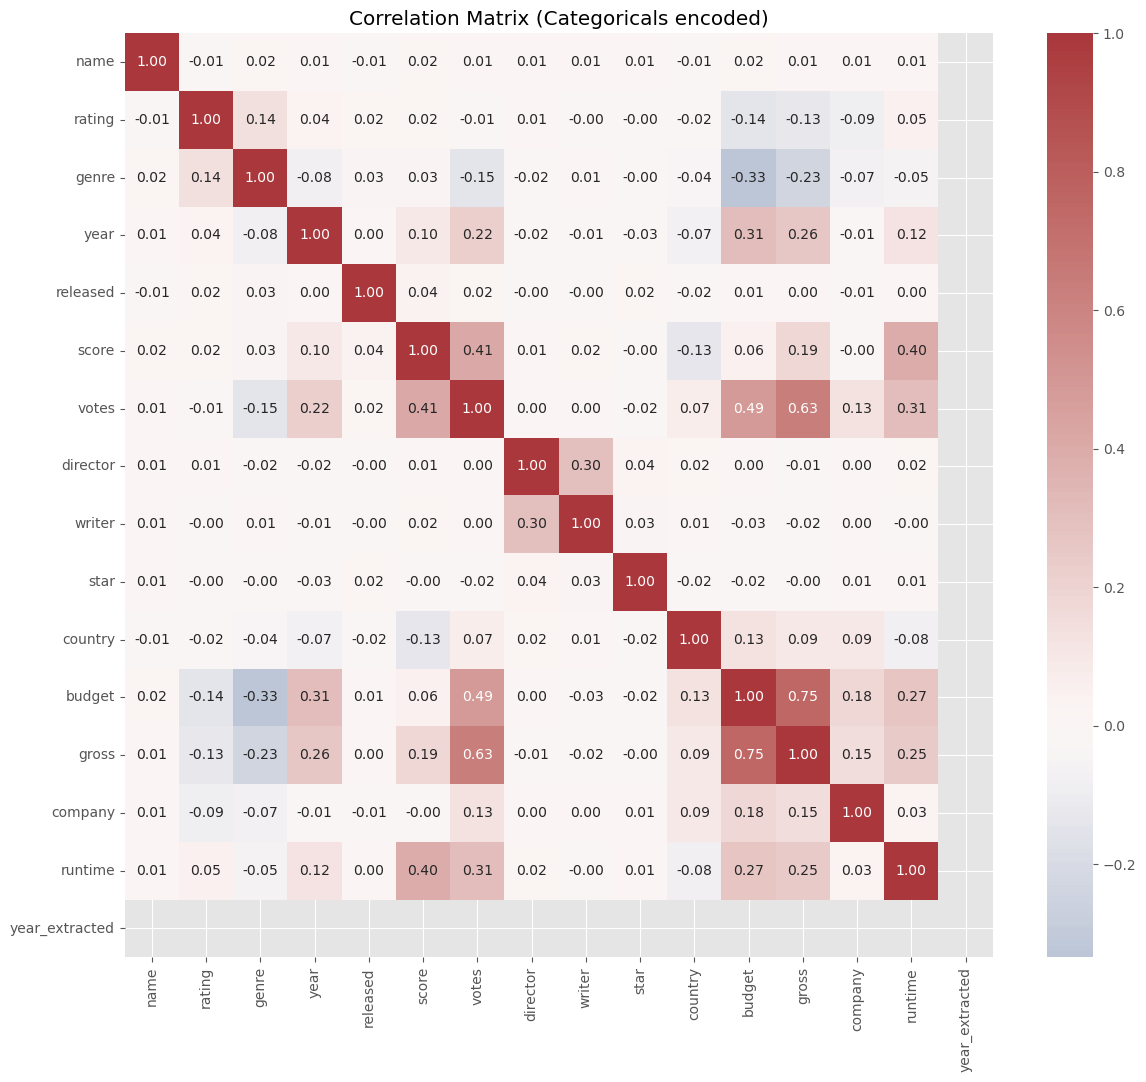

In [29]:
# Correlation on numerized DataFrame
num_corr_all = df_numerized.corr(method='pearson')
plt.figure(figsize=(14,12))
sns.heatmap(num_corr_all, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation Matrix (Categoricals encoded)')
plt.show()

## 11. Extract strongest correlation pairs


Lists strongest positive and negative correlations (excluding self-correlation) to find relationships worth investigating.

In [30]:
corr_pairs = num_corr_all.unstack().sort_values(kind='quicksort')

In [31]:
# Remove self correlations
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

In [33]:
print('\nTop 10 strongest positive correlations:')
print(corr_pairs[corr_pairs > 0].drop_duplicates().sort_values(ascending=False).head(10))


Top 10 strongest positive correlations:
gross    budget      0.750157
votes    gross       0.632834
         budget      0.486862
         score       0.409182
runtime  score       0.399451
         votes       0.309212
budget   year        0.309212
writer   director    0.299511
runtime  budget      0.269510
year     gross       0.261900
dtype: float64


In [34]:
print('\nTop 10 strongest negative correlations:')
print(corr_pairs[corr_pairs < 0].drop_duplicates().sort_values().head(10))


Top 10 strongest negative correlations:
genre    budget    -0.334021
gross    genre     -0.234297
votes    genre     -0.145307
rating   budget    -0.141346
country  score     -0.134642
rating   gross     -0.129019
         company   -0.092892
genre    year      -0.081261
runtime  country   -0.079325
company  genre     -0.069928
dtype: float64


## 12. Useful aggregations — top companies by total gross


Shows which production companies have the largest summed box-office gross (top 15). This is useful as a business insight.


Top 15 companies by total gross:


,gross
company,
Warner Bros.,56491421806
Universal Pictures,52514188890
Columbia Pictures,43008941346
Paramount Pictures,40493607415
Twentieth Century Fox,40257053857
Walt Disney Pictures,36327887792
New Line Cinema,19883797684
Marvel Studios,15065592411
DreamWorks Animation,11873612858


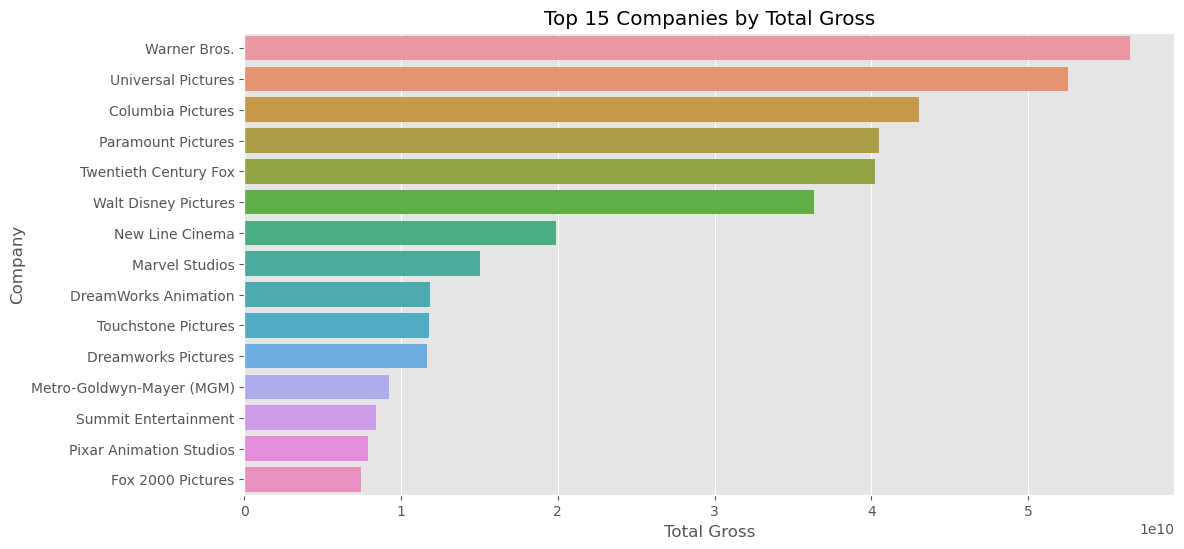

In [35]:
if 'company' in df_clean.columns:
    top_companies = df_clean.groupby('company', dropna=True)[['gross']].sum().sort_values('gross', ascending=False).head(15)
    top_companies['gross'] = top_companies['gross'].astype('int64')
    print('\nTop 15 companies by total gross:')
    display(top_companies)
    
    # Bar plot
    plt.figure(figsize=(12,6))
    sns.barplot(x=top_companies['gross'], y=top_companies.index)
    plt.title('Top 15 Companies by Total Gross')
    plt.xlabel('Total Gross')
    plt.ylabel('Company')
    plt.show()

## 13. Year-wise trends

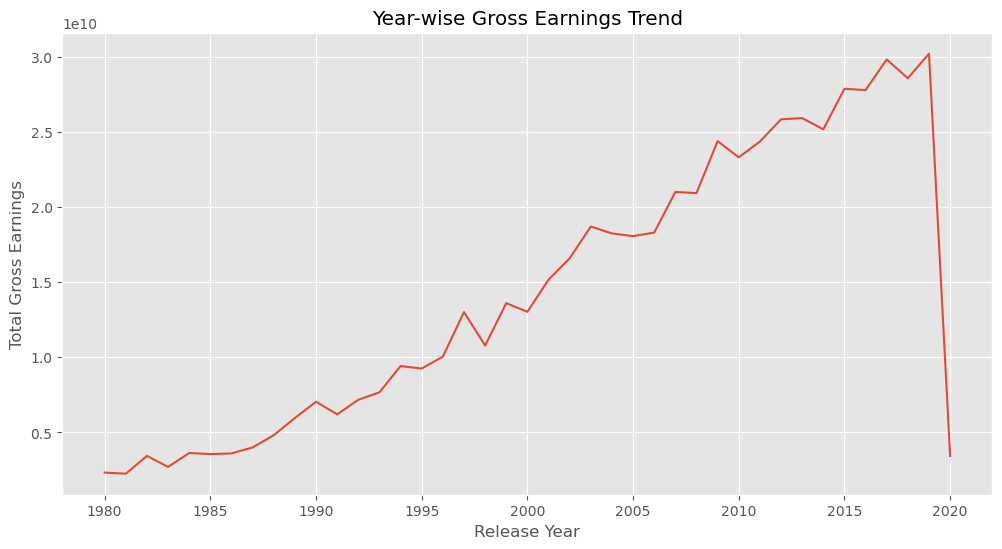

In [41]:
# Extract year safely from the 'released' column
df['year'] = df['released'].astype(str).str.extract(r'(\d{4})')

# Convert to numeric, ignore NaN (avoids conversion errors)
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Drop rows where year is missing
df = df.dropna(subset=['year'])

# Convert year to integer after cleaning
df['year'] = df['year'].astype(int)

# Group by year and calculate total gross
yearly_gross = df.groupby('year')[['gross']].sum().reset_index()

# Plot trend
plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_gross, x='year', y='gross')
plt.title("Year-wise Gross Earnings Trend")
plt.xlabel("Release Year")
plt.ylabel("Total Gross Earnings")
plt.show()


# Key Findings & Supporting Analysis

### 1. Strongest Correlation: Budget vs. Gross 💰
The analysis confirms that a movie’s budget has the strongest relationship with its gross earnings.  
- **Support:** The Pearson Correlation Matrix (Section 9) reports a correlation coefficient of **0.75**.  
- **Visualization:** The "Budget vs Gross" scatter plot (Section 7) shows a clear, upward-sloping linear trend.

### 2. Second Strongest: Votes vs. Gross 📈
Audience engagement, measured by the number of votes, is the next most correlated numerical feature.  
- **Support:** The Pearson Correlation Matrix (Section 9) shows a correlation coefficient of **0.63**.

### 3. Genre Complexity 🎬
The relationship between genre and gross is more nuanced.  
- **Support:** The numerized correlation matrix (Section 10) shows a negative correlation (**-0.23**) between encoded genres and gross, indicating a non-obvious or inverse trend that requires careful interpretation.

### 4. Top Companies 🏆
The list of top-grossing production companies is accurately reported.  
- **Support:** Aggregation in Section 12 ("Top 15 Companies by Total Gross") ranks **Warner Bros., Universal Pictures, and Columbia Pictures** as the top three.

### 5. Time Trend 📅
The market shows an overall upward trend in gross earnings over time.  
- **Support:** The line plot in Section 13 ("Year-wise Gross Earnings Trend") visually demonstrates a significant increase in total gross earnings from 1980 onward.

**Conclusion:**  
These insights accurately reflect the quantitative correlations and visual trends in the dataset, making them actionable for strategic decisions and further analysis.
